## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

import random
import os
import pickle
import time
from copy import deepcopy

# 만약 opencv-python이 설치되어있지 않다면 다음을 통해서 설치해주세요.
# pip install opencv-python
# 만약 설치에 오류가 발생한다면 다음을 참고해주세요.
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_table_of_contents_setup/py_table_of_contents_setup.html#py-table-of-content-setup
from wrappers import wrap

## 하이퍼 파라미터 정의하기

In [2]:
'''DQN settings'''
# sequential images to define state
STATE_LEN = 4
# target policy sync interval
TARGET_REPLACE_ITER = 1
# simulator steps for start learning
LEARN_START = 10**2
# (prioritized) experience replay memory size
MEMORY_CAPACITY = 10**4
# simulator steps for learning interval
LEARN_FREQ = 1

'''Environment Settings'''
# openai gym env name 
# https://gym.openai.com/envs/CartPole-v1/
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape
# Total simulation step
STEP_NUM = 10**5
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 1e-4
# epsilon-greedy
EPSILON = 0.0

'''Save&Load Settings'''
# check save/load
SAVE = True
LOAD = False
# save frequency
SAVE_FREQ = 10**4
# paths for predction net, target net, result log
PRED_PATH = './data/model/pred_net_simple.pkl'
TARGET_PATH = './data/model/target_net_simple.pkl'
RESULT_PATH = './data/plots/result_simple.pkl'

USE GPU: True


## 네트워크 구조 정의하기

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # nn.Sequential을 사용하면 다음과 같입 코드를 간결하게 바꿀 수 있습니다.
        self.feature_extraction = nn.Sequential(
            nn.Linear(N_STATES[0] * STATE_LEN , 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        # action value function
        self.fc_q = nn.Linear(128, N_ACTIONS) 
            
        # 파라미터 값 초기화 코드는 다음과 같이 간결하게 바꿀 수 있습니다.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x는 (m, 84, 84, 4)의 tensor
        x = self.feature_extraction(x)
        action_value = self.fc_q(x)
        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

## DQN 정의하기

In [4]:
class DQN(object):
    def __init__(self):
        self.pred_net, self.target_net = Net(), Net()
        # sync eval target
        self.update_target(self.target_net, self.pred_net, 1.0)
        # use gpu
        if USE_GPU:
            self.pred_net.cuda()
            self.target_net.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        # target network step counter
        self.learn_step_counter = 0
        
        # ceate the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr=LR)
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
            
    def save_model(self):
        # save prediction network and target network
        self.pred_net.save(PRED_PATH)
        self.target_net.save(TARGET_PATH)

    def load_model(self):
        # load prediction network and target network
        self.pred_net.load(PRED_PATH)
        self.target_net.load(TARGET_PATH)

    def choose_action(self, x, EPSILON):
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()

        if np.random.uniform() < EPSILON:
            # greedy case
            action_value = self.pred_net(x.unsqueeze(0))
            action = torch.argmax(action_value).data.cpu().numpy()
        else:
            # random exploration case
            action = np.random.randint(0, N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))

    def learn(self, beta):
        self.learn_step_counter += 1
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.update_target(self.target_net, self.pred_net, 1e-2)
        
        # data sample from experience replay
        b_state_memory, b_action_memory, b_reward_memory, \
        b_next_state_memory, b_done = self.replay_buffer.sample(BATCH_SIZE)
        b_weights, b_idxes = np.ones_like(b_reward_memory), None
            
        b_s = torch.FloatTensor(b_state_memory)
        b_a = torch.LongTensor(b_action_memory)
        b_r = torch.FloatTensor(b_reward_memory)
        b_s_ = torch.FloatTensor(b_next_state_memory)
        b_d = torch.FloatTensor(b_done)

        if USE_GPU:
            b_s, b_a, b_r, b_s_, b_d = b_s.cuda(), b_a.cuda(), b_r.cuda(), b_s_.cuda(), b_d.cuda()

        # action value prediction
        q_eval = self.pred_net(b_s).gather(1, b_a.unsqueeze(1)).view(-1)
        # shape : (m)
        # get next state value
        q_next = self.target_net(b_s_).detach()
        # get target value
        q_target = b_r + GAMMA *(1.-b_d)* q_next.max(1)[0]
        # shape (m)
            
        # calc huber loss, dont reduce for importance weight
        loss = F.smooth_l1_loss(q_eval, q_target, reduction='none')
        # calc importance weighted loss
        b_w = torch.Tensor(b_weights)
        if USE_GPU:
            b_w = b_w.cuda()
        loss = torch.mean(b_w*loss)
        
        # backprop loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.pred_net.parameters(),1.)
        self.optimizer.step()

## 학습

In [5]:
dqn = DQN()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    dqn.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward (since we are using EpisodicLifeEnv of OpenAI gym wrapper)
epi_step = 0
# accumulate return of current episode
entire_ep_r = 0.
# log for accumulate returns
entire_ep_rs = []
# check learning time
start_time = time.time()

while dqn.memory_counter <= STEP_NUM:
    # env reset
    s = np.array(env.reset())
    # concat states
    s_cat = [s] * STATE_LEN
    s_cat_ = [s] * STATE_LEN
    
    # initialize one episode reward
    ep_r = 0.

    while True:
        a = dqn.choose_action(np.reshape(np.array(s_cat),(N_STATES[0] * STATE_LEN)), EPSILON)

        # take action and get next state
        s_, r, done, info = env.step(a)
        s_cat_.append(s_)
        s_cat_.pop(0)

        # accumulate return
        ep_r += r
        # clip rewards for numerical stability
        if r >= 0:
            clip_r = 0.
        else:
            clip_r = r

        # store the transition
        dqn.store_transition(np.reshape(np.array(s_cat),(N_STATES[0] * STATE_LEN)), \
                             a, clip_r, np.reshape(np.array(s_cat_),(N_STATES[0] * STATE_LEN)),\
                             float(done))

        # annealing the epsilon(exploration strategy), beta(per smoothing)
        if dqn.memory_counter <= MEMORY_CAPACITY:
            # linear annealing to 0.9 until million step
            EPSILON += 0.9/MEMORY_CAPACITY
        elif dqn.memory_counter <= STEP_NUM:
            # linear annealing to 0.99 until the end
            EPSILON += 0.09/(STEP_NUM - MEMORY_CAPACITY)

        # if memory fill 50K and mod 4 = 0(for speed issue), learn pred net
        if (LEARN_START <= dqn.memory_counter) and (dqn.memory_counter % LEARN_FREQ == 0):
            dqn.learn(0.)
            
        # print log and save
        if dqn.memory_counter % SAVE_FREQ == 0:
            # check time interval
            time_interval = round(time.time() - start_time, 2)
            # calc mean return
            mean_10_ep_return = round(np.mean(entire_ep_rs[-10:-1]),2)
            result.append(mean_10_ep_return)
            # print log
            print('Ep: ',epi_step,
                  '| Mean ep 10 return: ', mean_10_ep_return,
                  '/Used Time:',time_interval,
                  '/Used Step:',dqn.memory_counter)
            # save model
            dqn.save_model()
            pkl_file = open(RESULT_PATH, 'wb')
            pickle.dump(np.array(result), pkl_file)
            pkl_file.close()
            print('Save complete!')
            
        # if agent meets end-of-life, update return, acc return
        if done:
            entire_ep_r += ep_r
            epi_step += 1
            if epi_step % 1 == 0:
                entire_ep_rs.append(entire_ep_r)
                entire_ep_r = 0.
            break

        s_cat = deepcopy(s_cat_)

        if RENDERING:
            env.render()

Initialize results!
Ep:  232 | Mean ep 10 return:  226.67 /Used Time: 22.56 /Used Step: 10000
Save complete!
Ep:  289 | Mean ep 10 return:  82.0 /Used Time: 46.47 /Used Step: 20000
Save complete!
Ep:  374 | Mean ep 10 return:  100.44 /Used Time: 70.44 /Used Step: 30000
Save complete!
Ep:  465 | Mean ep 10 return:  80.0 /Used Time: 94.21 /Used Step: 40000
Save complete!
Ep:  559 | Mean ep 10 return:  117.0 /Used Time: 118.13 /Used Step: 50000
Save complete!
Ep:  634 | Mean ep 10 return:  160.0 /Used Time: 142.16 /Used Step: 60000
Save complete!
Ep:  706 | Mean ep 10 return:  126.0 /Used Time: 166.63 /Used Step: 70000
Save complete!
Ep:  775 | Mean ep 10 return:  202.78 /Used Time: 191.23 /Used Step: 80000
Save complete!
Ep:  829 | Mean ep 10 return:  225.56 /Used Time: 215.76 /Used Step: 90000
Save complete!
Ep:  880 | Mean ep 10 return:  226.11 /Used Time: 239.56 /Used Step: 100000
Save complete!


## 결과 시각화

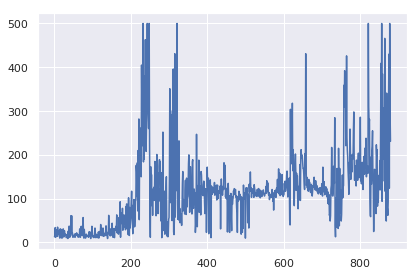

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

plt.plot(range(len(entire_ep_rs)), entire_ep_rs)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./simple_result.gif', writer='imagemagick', fps=30)

Total Reward : 460.00


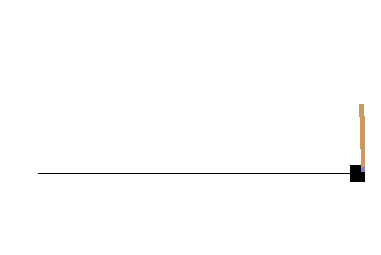

In [8]:
env = gym.make('CartPole-v1')
s = env.reset()
s_cat = [s] * STATE_LEN
s_cat_ = [s] * STATE_LEN
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a = dqn.choose_action(np.reshape(np.array(s_cat),(N_STATES[0] * STATE_LEN)), EPSILON)
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_cat_.append(s_)
    s_cat_.pop(0)
    total_reward += r
    if done:
        break
    s_cat = deepcopy(s_cat_)
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./simple_result.gif "segment")